In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import torch
from bert_training import training
from copy import deepcopy
from pathlib import Path
from sklearn.metrics import matthews_corrcoef
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import FillMaskPipeline, TextClassificationPipeline, pipeline
sns.set(font_scale=1.5)

Using TensorFlow backend.


In [2]:
## Random seeds to shuffle the trianing data.
RANDOM_SEEDS = np.random.choice(1000, 200, replace=False).tolist()

## BERT models.
BERT = 'bert-base-uncased'

## Data of interest.
TRAIN_DIR = Path('./data/CoLA/cola_in_domain_train.csv')
TEST_DIR = Path('./data/li-adger_sentences.csv')


In [3]:
## Load the .csv file with human data into memory.
train_data = pd.read_csv(TRAIN_DIR, index_col=0)
test_data = pd.read_csv(TEST_DIR)[['id', 'sentence', 'dataset']]

# Create new dataframe only with unique sentences and human judgements.
test_data = test_data.drop_duplicates(subset=['id'], keep='first').rename(columns={'regularizedSentence':'sentence'}).reset_index(drop=True)

# Get expert labels for each sentence.
test_data['label'] = (test_data.id.str.contains('g')).astype('int32')


In [4]:
## Set up CUDA for training.
if torch.cuda.is_available():  # Tell PyTorch to use the GPU. 
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('Will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Will use the GPU: GeForce RTX 2080 Ti


In [5]:
## Helper function to apply Sequence Classification pipeline to a Pandas DataFrame.
def sentence_acc_score(dataframe, sent_col='sentence', acc_pipeline=None):
    sentences = dataframe[sent_col].values.tolist()
    
    try: # Check whether all the sentences can be processed simultaneously.
        results = pd.DataFrame(acc_pipeline(sentences))
    except: # Batch them if not.
        n = 500 # Batch size.
        results = []
        for i in range(0, len(sentences), n):
            batch = sentences[i:i+n] if i+n < len(sentences) else sentences[i:]
            results += acc_pipeline(batch)
            torch.cuda.empty_cache()
        results = pd.DataFrame(results)
    
    results = pd.DataFrame(acc_pipeline(sentences))
    results.label.replace({'LABEL_0':0, 'LABEL_1':1}, inplace=True)
    
    return results

In [39]:
def f1_score(y_pred, y_true):
    matches = y_true.compare(y_pred, keep_shape=True, keep_equal=True)
    
    false_positives = matches.loc[np.logical_and(y_true==0, y_pred==1.0)].shape[0]
    true_positives = y_pred.loc[np.logical_and(y_true==1.0, y_pred==1.0)].shape[0]
    
    precision = true_positives/(true_positives + false_positives)
    recall = true_positives/y_true.loc[y_true == 1].shape[0]
    
    return 2 * (precision * recall)/(precision + recall)

In [7]:
## Load first pretrained BERT.
bert = BertForSequenceClassification.from_pretrained(BERT)
tokenizer = BertTokenizer.from_pretrained(BERT)

# Initialize a Sequence Classification pipeline for testing.
bert_pipeline = pipeline(task='sentiment-analysis', model=bert, tokenizer=tokenizer, device=0)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
## Apply the pipeline to the test data before training.
baseline = sentence_acc_score(test_data, sent_col='sentence', acc_pipeline=bert_pipeline)
test_data['baseline'] = baseline.label.values

# Clear GPU memory (NOTE: using torch.cuda.empty_cache() is bad practice...).
#bert.to("cpu")
#bert_pipeline = None
torch.cuda.empty_cache()

In [9]:
seed_performance = []
for seed in RANDOM_SEEDS:
    # Copy the original model and offload it to the GPU.
    bert_cola = deepcopy(bert)
    
    # Create new pipeline.
    bert_cola_pipeline = pipeline(task='sentiment-analysis', model=bert_cola, tokenizer=tokenizer, device=0)
  
    # Test pipeline to make sure it executes the same predictions as baseline.
    new_pred = sentence_acc_score(test_data, sent_col='sentence', acc_pipeline=bert_cola_pipeline)
    torch.cuda.empty_cache()
    
    if not test_data.baseline.compare(new_pred.label).empty:
        print("Predictions on test set before training changed!")
        print("Skipping training for random seed {}...".format(seed))
        continue

    # Train the model and recreate the pipeline.
    #bert_cola.to(device)
    shuffled_data = train_data.sample(frac=1, random_state=seed).reset_index(drop=True)
    bert_cola = training(bert_cola, tokenizer, device, shuffled_data, random_seed=seed)
    torch.cuda.empty_cache()

    bert_cola_pipeline = pipeline(task='sentiment-analysis', model=bert_cola, tokenizer=tokenizer, device=0)
    
    # Get new predictions from test data after fine-tuning with CoLA.
    new_pred = sentence_acc_score(test_data, sent_col='sentence', acc_pipeline=bert_cola_pipeline)
    torch.cuda.empty_cache()

    test_data['seed{}'.format(seed)] = new_pred.label.values
    
    # Get accuracy of the random seed.
    f1 = f1_score(test_data['seed{}'.format(seed)], test_data.label)
    mcc = matthews_corrcoef(test_data.label, test_data['seed{}'.format(seed)])
    seed_performance.append(mcc)
    print("Random seed {} performance:\n".format(seed) +\
          "F1 score: {}\n".format(f1) +\
          "MCC score: {}".format(mcc))
    
    # Clear GPU memory again for next iteration...
    bert_cola = None
    bert_cola_pipeline = None
    torch.cuda.empty_cache()

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)

==== First Transformer ====

bert.embeddings.position_embeddings.weight                (512, 768)

==== First Transformer ====

bert.embeddings.token_type_embeddings.weight                (2, 768)

==== First Transformer ====

bert.embeddings.LayerNorm.weight                              (768,)

==== First Transformer ====

bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)

==== Output Layer ====

bert.encoder.layer.0.attention.self.query.bias                (768,)

==== Output Layer ====

bert.encoder.layer.0.attention.self.key.weight            (768, 768)

==== Output Layer ====

bert.encoder.layer.0.attention.self.key.bias                  (768,)

==== Output Layer ====

bert.encoder.layer.0.attention.self.value.weight  

In [10]:
## Check which predictions flipped according to changes in training order.
test_data['flips'] = 0
test_data['num_flips'] = 0
flip_hist = []
for i in range(len(RANDOM_SEEDS)):
    seed1 = RANDOM_SEEDS[i]
    seed2 = RANDOM_SEEDS[i+1] if i+1 < len(RANDOM_SEEDS) else RANDOM_SEEDS[0]
    
    # Will return NaN values for rows that did not change.
    delta = test_data['seed{}'.format(seed1)].compare(test_data['seed{}'.format(seed2)], keep_shape=True)
    
    # Merge the two columns.  Rows that changed value will have a new value of 1.  Rows that didn't will still be NaN.
    delta = delta.self + delta.other
    
    # Change 0s to 1s for boolean logic.
    delta.replace(to_replace=0, value=1, inplace=True)
    
    # Replace NaN with 0 for boolean logic.
    delta.fillna(0, inplace=True)
    
    # Perform boolean addition on the current record of flipping sentences.
    test_data.flips = test_data.flips | delta.astype('int32')
    
    # Perform normal addition in order to tally how much each sentence flipped.
    test_data.num_flips += delta.astype('int32')
    
    # Get total of sentences that have flipped so far.
    flip_hist.append(test_data.flips.sum()/test_data.flips.shape)    
    
print("A total of {} sentences flipped across {} random seeds.".format(test_data.flips.sum(), len(RANDOM_SEEDS)))
print("This is {} percent of all the sentences in the test set!".format((test_data.flips.sum()/test_data.flips.shape)*100))

A total of 1272 sentences flipped across 200 random seeds.
This is [30.44518909] percent of all the sentences in the test set!


In [45]:
## Get all examples of sentences that flip.
acrobatic_sentence = test_data.loc[test_data.flips == 1]
acrobatic_sentence = acrobatic_sentence[['id', 'sentence', 'dataset', 'num_flips']]
print(acrobatic_sentence.sentence)

9       They appear to that Chris is the right person ...
10      She seems to that Garrett should be punished f...
11             I appear to that Data is an unsafe driver.
12                I seem to that Robert can't be trusted.
37                  Charles believed Faith to be unhappy.
                              ...                        
4134                   Which the train did you arrive on?
4135                 Which the bridesmaid did you escort?
4137                Which the teacher do you admire most?
4146                     I wondered could we leave early.
4149              I wondered could we find a replacement.
Name: sentence, Length: 1272, dtype: object


In [62]:
## Get f1 score that always predicts majority class.
majority_label = test_data.label.mode()[0]
majority_pred = pd.Series([majority_label] * test_data.label.shape[0]) 
# NOTE: the multiplication^^^ needs to be performed on a Python list, not on the array returned by pd.Series.mode().
baseline_f1 = f1_score(baseline_pred, test_data.label)
#baseline_mcc = matthews_corrcoef(test_data.label, baseline_pred)
random_pred = np.random.randint(0, 2, size=test_data.label.shape[0])
random_mcc = matthews_corrcoef(test_data.label, random_pred)

## Get baseline accuracy by predicting the majority class.
baseline_acc = test_data.label.value_counts().iloc[0]/test_data.label.shape[0]

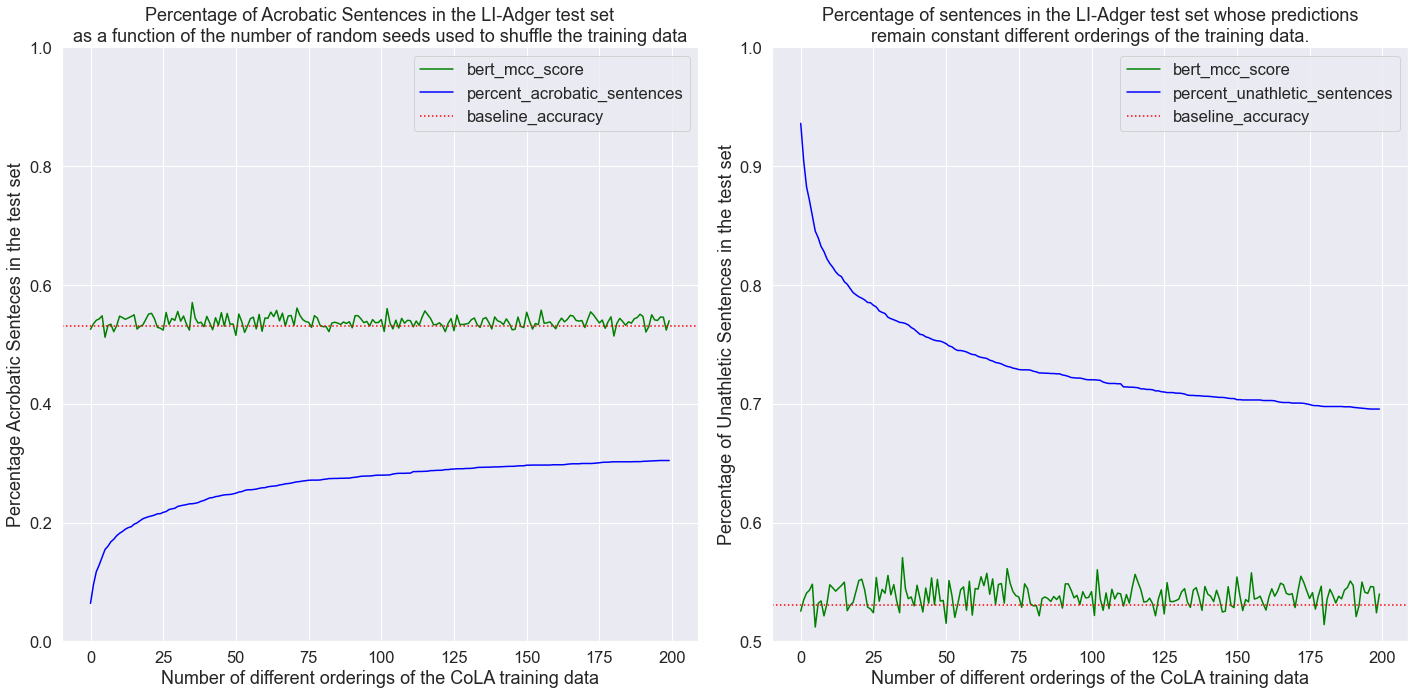

In [77]:
fig, axes = plt.subplots(ncols=2, figsize=(2* 10, 10))

# Draw the lines.
axes[0].plot(seed_performance, color="green", label='bert_mcc_score')
axes[0].plot(flip_hist, color="blue", label='percent_acrobatic_sentences')
#axes[0].axhline(random_mcc, color="red", label='random_mcc', linestyle='-.')
axes[0].axhline(baseline_acc, color="red", label='baseline_accuracy', linestyle=':')


axes[1].plot(seed_performance, color="green", label='bert_mcc_score')
axes[1].plot(1 - np.array(flip_hist), color="blue", label='percent_unathletic_sentences')
#axes[1].axhline(baseline_f1, color="red", label='baseline_f1', linestyle='-.')
axes[1].axhline(baseline_acc, color="red", label='baseline_accuracy', linestyle=':')

# Set axis bounds.
#ax.set_xticks(range(len(RANDOM_SEEDS)))
#ax.set_xticklabels(RANDOM_SEEDS)
axes[0].set_ylim(0.0, 1.0)
axes[1].set_ylim(0.5, 1.0)

# Label everything.
axes[0].set_title('Percentage of Acrobatic Sentences in the LI-Adger test set\n' +\
                'as a function of the number of random seeds used to shuffle the training data')
axes[1].set_title('Percentage of sentences in the LI-Adger test set whose predictions\n' +\
                 'remain constant different orderings of the training data.')

axes[0].set_xlabel("Number of different orderings of the CoLA training data")
axes[1].set_xlabel("Number of different orderings of the CoLA training data")

axes[0].set_ylabel("Percentage Acrobatic Senteces in the test set")
axes[1].set_ylabel("Percentage of Unathletic Sentences in the test set")

axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.savefig("./figures/bert_stability_testing.png")
plt.show()

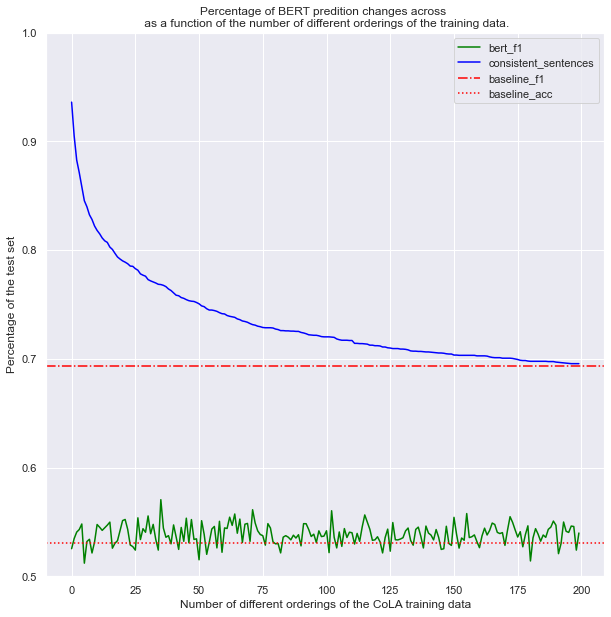

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))

# Draw the lines.
ax.plot(seed_performance, color="green", label='bert_f1')
ax.plot(1 - np.array(flip_hist), color="blue", label='consistent_sentences')
ax.axhline(baseline_f1, color="red", label='baseline_f1', linestyle='-.')
ax.axhline(baseline_acc, color="red", label='baseline_acc', linestyle=':')

# Set axis bounds.
#ax.set_xticks(range(len(RANDOM_SEEDS)))
#ax.set_xticklabels(RANDOM_SEEDS)
ax.set_ylim(0.5, 1.0)

# Label everything.
ax.set_title('Percentage of BERT predition changes across \n as a function of the number of different orderings of the training data.')
ax.set_xlabel("Number of different orderings of the CoLA training data")
ax.set_ylabel("Percentage of the test set")
ax.legend()

plt.show()

In [50]:
## Export data for further analyses.
np.savetxt("./output/bert_replicability_random_seeds.csv", RANDOM_SEEDS, delimiter=",")
test_data.to_csv("./output/bert_replicability_data.csv")
acrobatic_sentence.to_csv("./output/acrobatic_sentences.csv")

In [ ]:
## Import data from language modelling.
bert_data = pd.read_csv('./output/all_three_regularized/bert_acc_data.csv', index_col=0)

# Select only the rows that have to do with BERT.
bert_data = bert_data.loc[bert_data.measure.isin(['pseudoLogProb', 'acceptability'])]

# Average the BERT acceptability predictions across random seeds.
bert_data = bert_data.groupby(['id', 'measure', 'regularizedSentence', 'corpus', 'dataset'], as_index=False).mean()

In [ ]:
# Get only the outliers in BERT's predictions.
outliers = bert_data.loc[bert_data.probability < -60]

# Get the flipping outliers.
acro_outliers = outliers.loc[outliers.regularizedSentence.isin(acrobatic_sentences.sentence)]

In [ ]:
acro_outliers = outliers.loc[outliers.regularizedSentence.isin(acrobatic_sentences.sentence)]

In [ ]:
g = sns.FacetGrid(acro_outliers, col='measure', row='dataset', height=5, aspect=1,
                  sharey=False, sharex=False, margin_titles=True)
g.map(sns.scatterplot, "judgment", "probability", color=".3", y_jitter=.1)

plt.show()